# **Stock Price Forecasting using the ARIMA Time Series Model**



This project presents a comprehensive approach to forecasting the future stock prices of Apple Inc. (AAPL) using ARIMA and SARIMAX models, both of which are widely used techniques in time series forecasting. We start by collecting historical stock price data using the `yfinance` API and proceed with thorough data preprocessing including log transformation and stationarity testing using the Augmented Dickey-Fuller (ADF) test.

Exploratory Data Analysis (EDA) is conducted to examine the statistical properties and trends of the time series, followed by model development using both manual parameter tuning and automatic parameter selection through `auto_arima`. The ARIMA model is then fitted, and its performance is evaluated through residual diagnostics, forecast visualization, and error metrics including MAE, MSE, RMSE, and MAPE.

We also extend our analysis to the SARIMAX model to capture potential seasonal effects in the stock price data. The notebook ends with a comparative evaluation of forecast accuracy between ARIMA and SARIMAX models, along with confidence interval visualization to assess forecast uncertainty.

This end-to-end project serves as a practical and educational guide to building robust time series forecasting pipelines using Python and modern statistical tools.

## Part 1 - Setup and Data Collection

First, we begin by ensuring all necessary libraries are installed.

In [1]:
!pip install yfinance pandas matplotlib seaborn statsmodels
!pip install scikit-learn
!pip install numpy==1.26.4 pmdarima

Now, we will fetch historical stock price data from the yfinance library. In this project, we'll be using AAPL stock.

In [2]:
import yfinance as yf
import pandas as pd

ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-12-31"

stock_data = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000
2015-01-06,23.637512,23.897778,23.274918,23.699798,263188400
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600
2015-01-08,24.889906,24.947743,24.180291,24.298190,237458000


## Part 2 - Data Preprocessing

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2264 non-null   float64
 1   (High, AAPL)    2264 non-null   float64
 2   (Low, AAPL)     2264 non-null   float64
 3   (Open, AAPL)    2264 non-null   float64
 4   (Volume, AAPL)  2264 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 106.1 KB


In [5]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,81.673040,82.500388,80.763437,81.604385,1.237607e+08
std,56.182340,56.757619,55.545175,56.127499,6.818458e+07
min,20.674534,20.978904,20.475433,20.596721,2.404830e+07
25%,32.926908,33.123756,32.745150,32.939103,7.831732e+07
50%,51.395988,52.210079,51.020441,51.543370,1.056556e+08
75%,139.493008,141.184967,136.983602,139.434316,1.486811e+08
max,196.927658,198.428641,195.824279,196.838199,6.488252e+08


Now, we should plot the closing price to get an initial sense of the data.

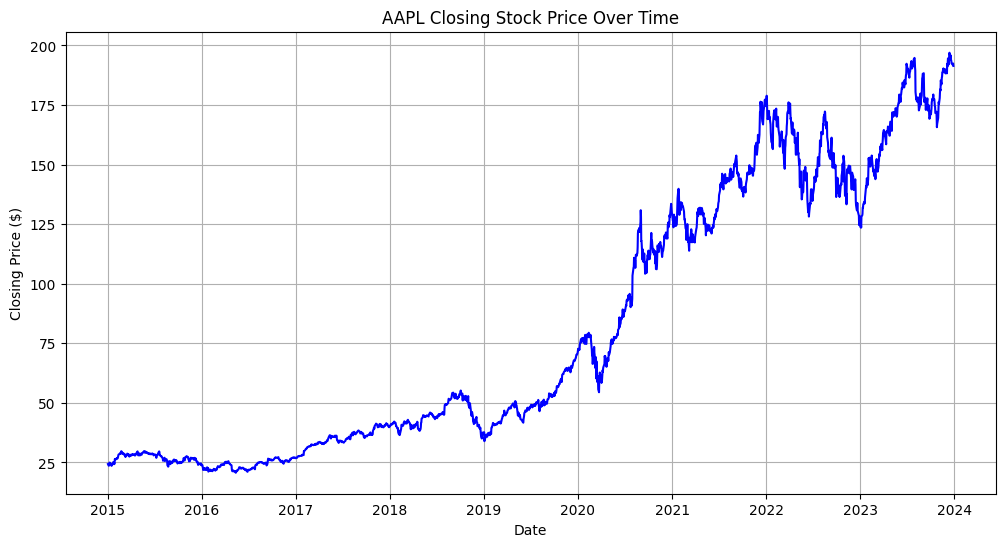

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title(f'{ticker} Closing Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

Here, we check whether any missing values exist in any of the 5 columns of the dataframe.

In [7]:
print(stock_data.isnull().sum())

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


We now perform log normalization on the Closing Price column in order to stabilize its variance.

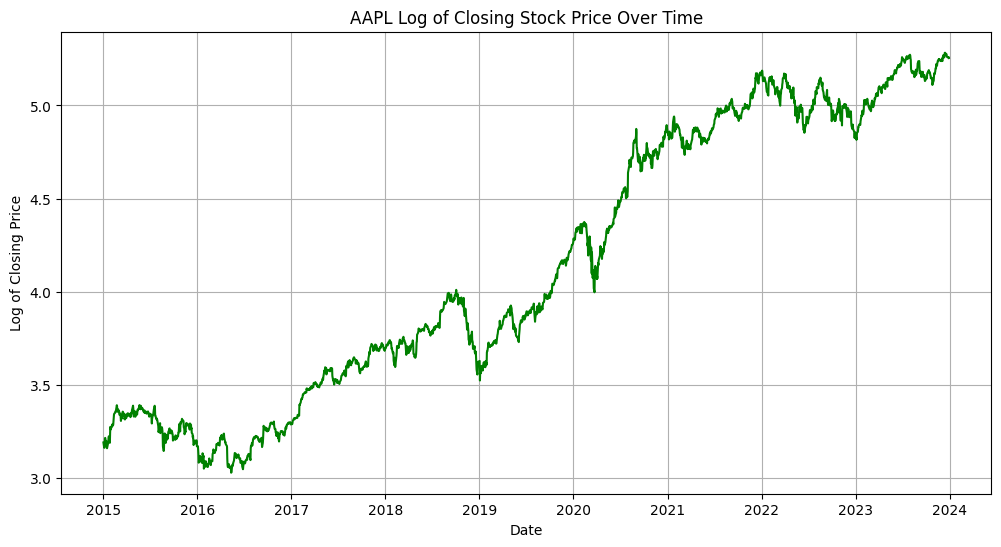

In [8]:
import numpy as np

df_close = stock_data['Close']
df_close_log = np.log(df_close)

# Visualizing the newly transformed data
plt.figure(figsize=(12, 6))
plt.plot(df_close_log, label='Log of Closing Price', color='green')
plt.title(f'{ticker} Log of Closing Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log of Closing Price')
plt.grid(True)
plt.show()

We now can conduct Exploratory Data Analysis (EDA) in order to understand the data better, as well as perform tests to determine/achieve stationarity (a key assumption for most time series models, including ARIMA.) Below, we retrieve a statistical summary of the closing prices, plot the closing prices' distribution to understand their skewness and kurtosis, and decompose the time series data to detect any relevant trends or seasonality.

In [9]:
# Statistical summary
df_close.describe()

Ticker,AAPL
count,2264.000000
mean,81.673040
std,56.182340
min,20.674534
25%,32.926908
50%,51.395988
75%,139.493008
max,196.927658


<Figure size 1200x600 with 0 Axes>

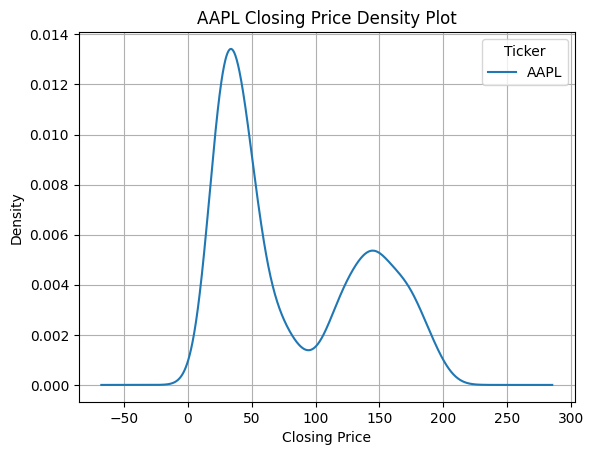

In [10]:
# Density Plot
plt.figure(figsize=(12, 6))
df_close.plot(kind='kde')
plt.title(f'{ticker} Closing Price Density Plot')
plt.xlabel('Closing Price')
plt.grid(True)
plt.show()

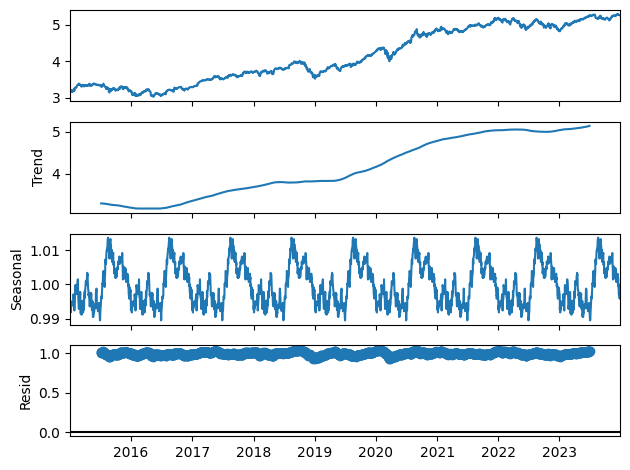

In [11]:
# Time series data decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# 252 - approximate number of trading days per year
result = seasonal_decompose(df_close_log, model='multiplicative', period=252)
result.plot()
plt.show()

We now conduct stationarity testing. We know that a stationary time series has constant mean and variance over time, as well as that most time series models assume stationarity. We use the Augmented Dickey-Fuller (ADF) test to test for stationarity.

In [12]:
from statsmodels.tsa.stattools import adfuller

# Create stationarity checking function
def test_stationarity(ts_data):
  # Initialize rolling stats
  rolling_mean = ts_data.rolling(window=12).mean()
  rolling_std = ts_data.rolling(window=12).std()

  # Plot rolling stats
  plt.figure(figsize=(12, 6))
  plt.plot(ts_data, label='Original Data', color='blue')
  plt.plot(rolling_mean, label='Rolling Mean', color='red')
  plt.plot(rolling_std, label='Rolling Std', color='green')
  plt.legend()
  plt.title('Rolling Mean and Standard Deviation')
  plt.show()

  # Perform ADF test for stationarity
  print("Results of Augmented Dickey-Fuller Test:")
  adf_test = adfuller(ts_data, autolag='AIC')

  # Initialize Series to store ADF test outputs
  adf_outputs = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in adf_test[4].items():
    adf_outputs[f'Critical Value ({key})'] = value
  print(adf_outputs)

To provide further context, we know that the ADF test checks whether a time series has a "unit root" (specifically, a "unit root" indicates a non-stationary process where the current value depends on its past values, and the series doesn't tend to revert to a long-run mean, instead drifting over time.)

Moreover, the ADF test statistic is calculated based on how strongly the time series data appears to revert to a mean.

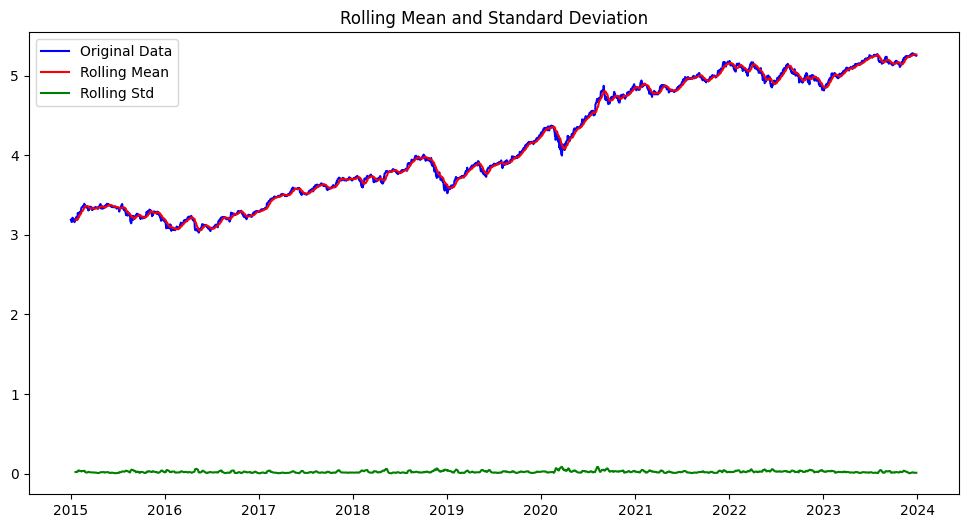

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -0.388165
p-value                           0.912056
#Lags Used                        9.000000
Number of Observations Used    2254.000000
Critical Value (1%)              -3.433255
Critical Value (5%)              -2.862823
Critical Value (10%)             -2.567453
dtype: float64


In [13]:
test_stationarity(df_close_log)

Interpreting the outputs above:

The critical values are thresholds that show how extreme a test statistic needs to be in order to viably reject the null hypothesis (which, in this case, is that **the time series data is non-stationary**) at a given significance level.

Because the test statistic is much greater than any of the critical values computed using the ADF test, because the outputted p-value is much larger than 0.05, and because there is a strong upward trend in the rolling mean, we fail to reject the null hypothesis, implying that the provided time series data is non-stationary.

Therefore, we need to apply differencing in order to achieve stationarity.

In [14]:
# .diff() computes the difference between each value and its previous value
# .dropna() removes any NaNs from the data
df_close_log_diff = df_close_log.diff().dropna()

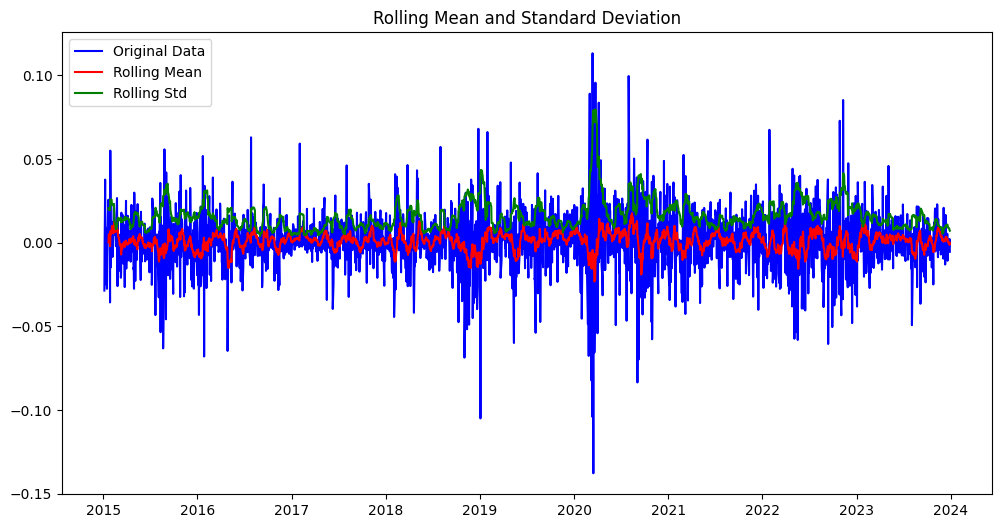

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.471526e+01
p-value                        2.806486e-27
#Lags Used                     8.000000e+00
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [15]:
test_stationarity(df_close_log_diff)

After performing the differencing, we are able to see that the transformed data has indeed achieved stationarity (the test statistic is significantly lower than any of the critical value thresholds, the p-value is essentially 0, and visually, the rolling mean appears centered around 0.)

## Part 3 - Model Development

Now, we begin the process of setting up the ARIMA model itself - determining the model's optimal parameters, splitting the data correctly, as well as building and fitting the model.

First, to identify potential values of p and q (ARIMA parameters), we can plot two graphs - the autocorrelation and partial autocorrelation plots (ACF and PACF.)

The ACF plot measures the correlation of a time series with its own lags (specifically, how correlated a time series is with itself 1 time steps ago, 2 time steps ago, etc.) and is used for the MA (or moving average) component, q, of the ARIMA model. Additionally, the PACF plot measures the correlation of a time series with its lags **after removing the effects of all shorter lags** and helps to identify the AR (or autoregressive) component, p.

Both ACF and PACF assume stationarity, which is why we use the df_close_log_diff transformed time series data.

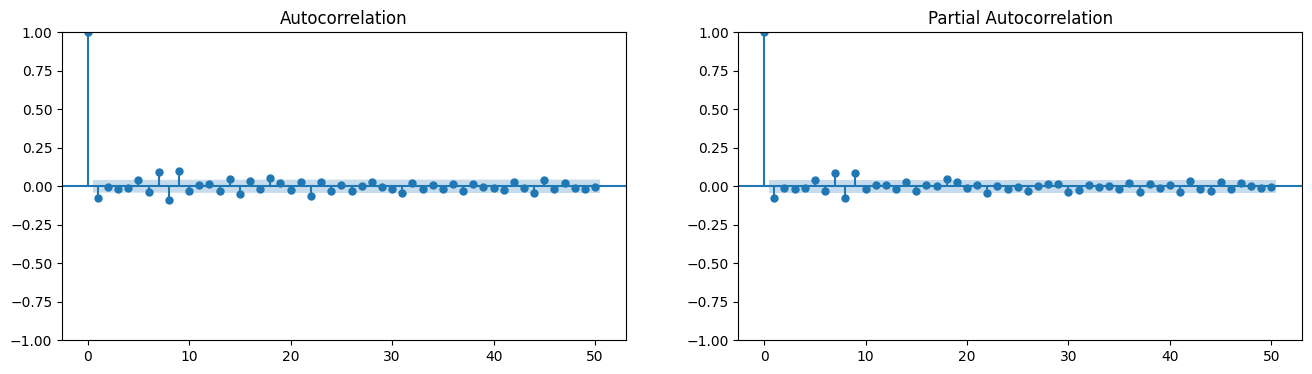

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_close_log_diff, lags=50, ax=axes[0])
plot_pacf(df_close_log_diff, lags=50, ax=axes[1])
plt.show()

Along with using the ACF and PACF plots, we can also use the *pmdarima* library and its *auto_arima* function to automatically determine what the optimal (p, d, q) parameters for the ARIMA model are.

Here, we use df_close_log because we allow the *auto_arima* function to automatically difference the data.





/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11692.060, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11682.842, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11693.669, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11693.898, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11679.231, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11691.994, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11692.086, Time=5.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11689.286, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 8.326 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2264
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5849.949
Date:                Thu, 10 Apr 2025   AIC                         -11693.898
Time:                        15:42:37   BIC                         -11676.725
Sample:                             0   HQIC                        -11687.632
                               - 2264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.528      0.011       0.00

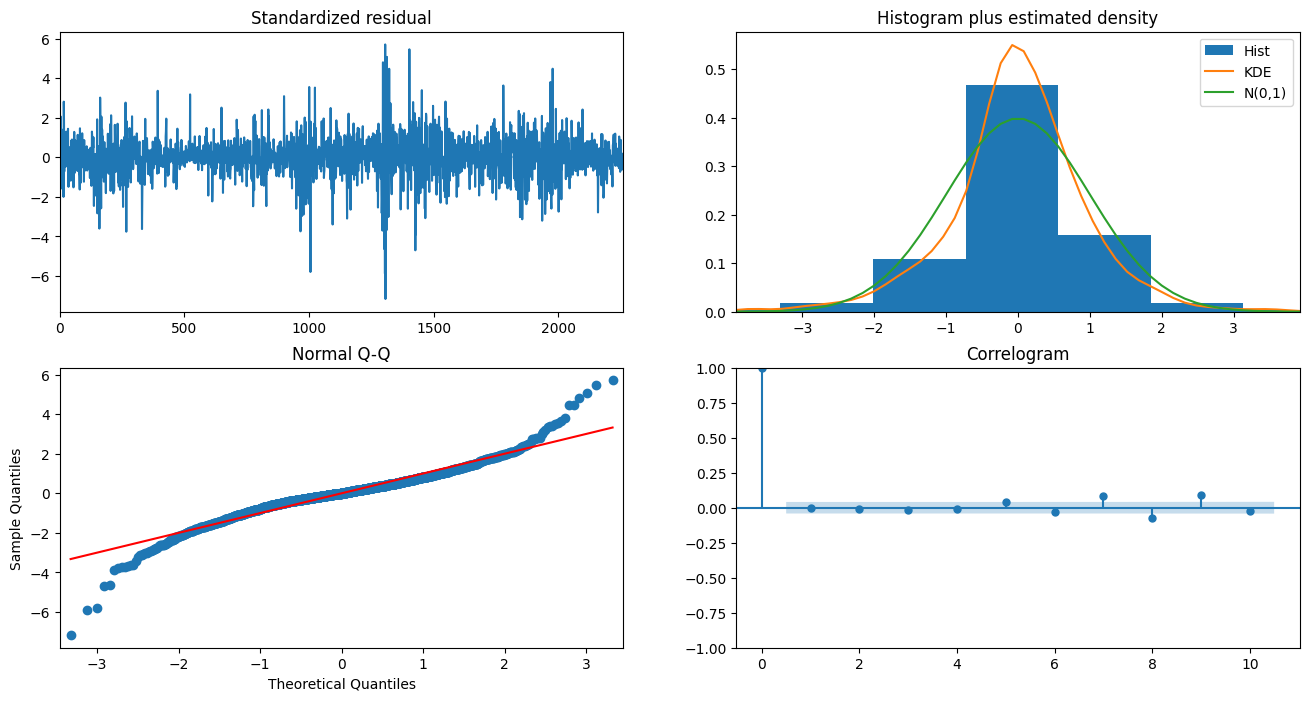

In [49]:
import pmdarima as pm

model_autoARIMA = pm.auto_arima(df_close_log, start_p=1, start_q=1, test="adf", \
                                max_p=5, max_q=5, m=1, d=None, seasonal=False, \
                                start_P=0, D=0, trace=True, error_action='ignore', \
                                suppress_warnings=True, stepwise=True)

print(model_autoARIMA.summary())

model_autoARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

Interpreting the results above:

The AIC (Akaike Information Criterion) is a measure of model quality that balances goodness-of-fit with model complexity. Lower AIC values indicate better models, as they suggest a model that explains the data well without overfitting. In the context of `auto_arima`, AIC is used to guide the stepwise search through different combinations of (p, d, q) parameters.

When comparing multiple ARIMA or SARIMAX models, the one with the **lowest AIC** is typically considered the most suitable. However, it's also important to validate that residuals are white noise and that the model generalizes well to unseen data (i.e., has good forecasting performance). Thus, AIC should be considered in conjunction with diagnostic plots and evaluation metrics like RMSE and MAPE.

We now begin building the actual ARIMA model itself.

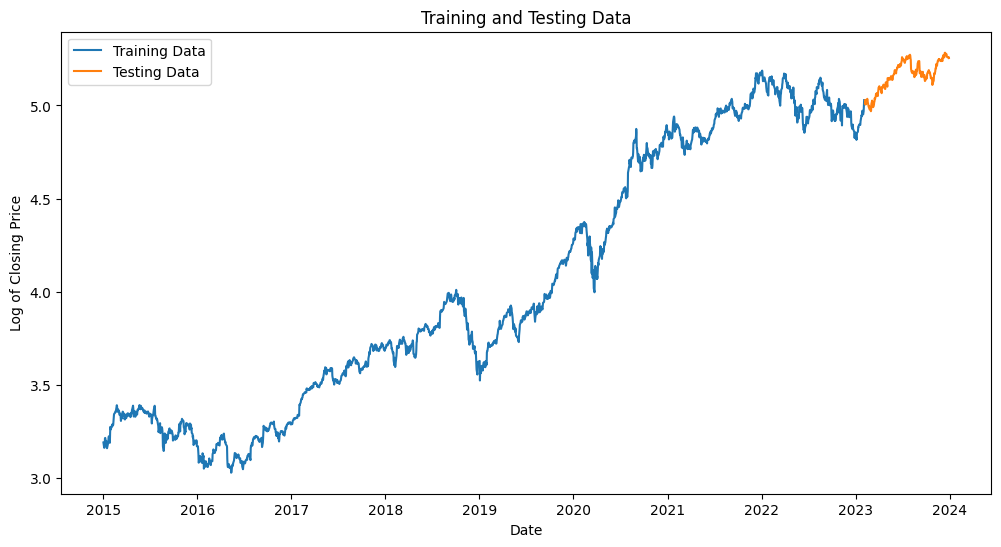

In [111]:
# Splitting data into train and test sets
train_size = int(len(df_close_log) * 0.9)
train_data, test_data = df_close_log[:train_size], df_close_log[train_size:]
# train_data, test_data = df_close_log_diff[:train_size], df_close_log_diff[train_size:] # (1, 0, 1) assumes stationarity

# Plotting train/test data
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("Log of Closing Price")
plt.legend()
plt.show()

In [95]:
# Fitting ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=model_autoARIMA.order)
# model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2037
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5199.695
Date:                Thu, 10 Apr 2025   AIC                         -10395.391
Time:                        16:42:00   BIC                         -10384.153
Sample:                             0   HQIC                        -10391.268
                               - 2037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0788      0.015     -5.420      0.000      -0.107      -0.050
sigma2         0.0004   6.41e-06     55.193      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

## Part 4 - Evaluation

In this section, we now conduct 3 steps - running model diagnostics (i.e., residual analysis), using the model to actually forecast future stock prices, and computing and interpreting performance metrics of the ARIMA model.

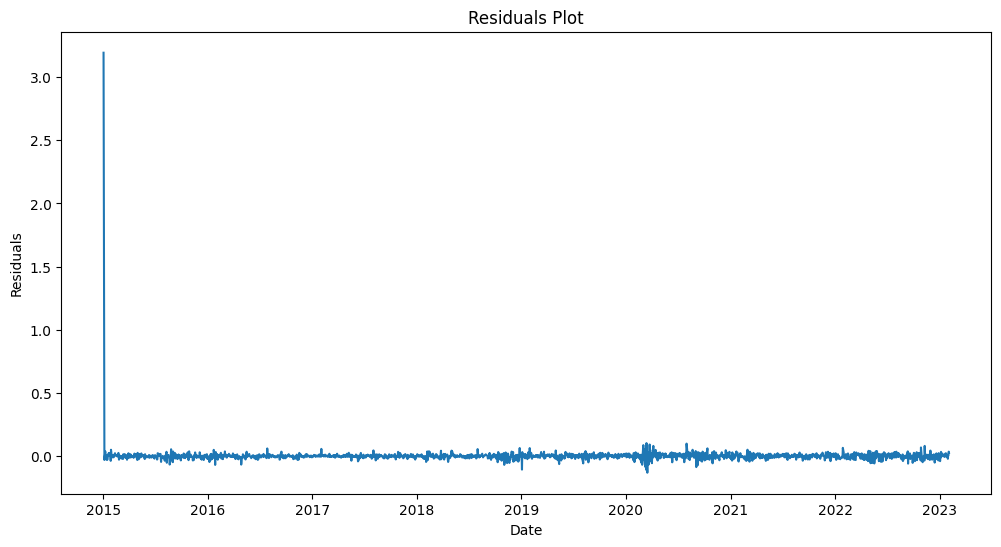

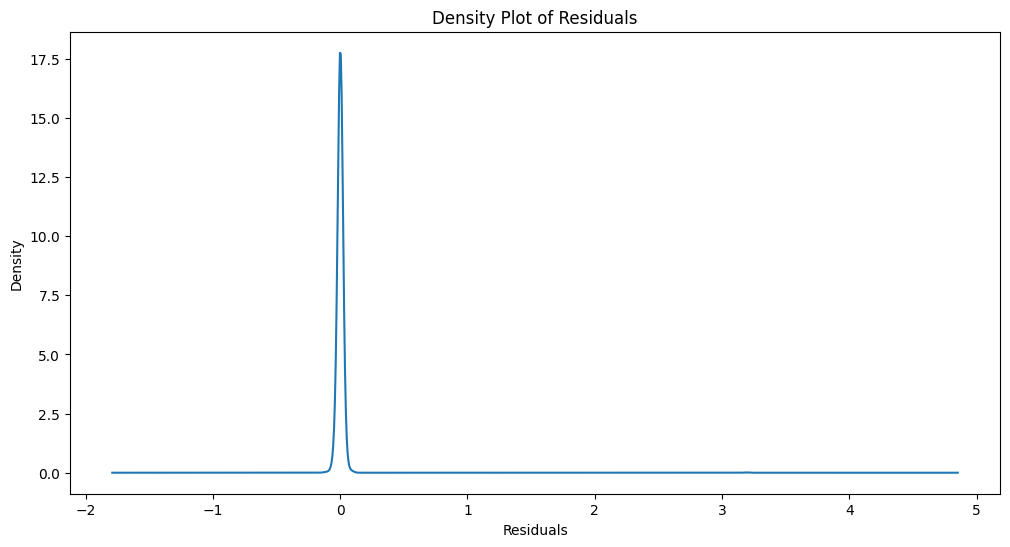

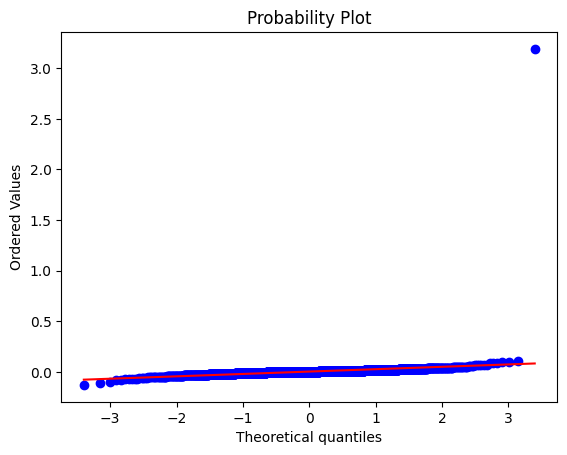

In [96]:
# Residual analysis
import scipy.stats as stats
import pylab

residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Residuals Plot")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(12, 6))
residuals.plot(kind='kde')
plt.title("Density Plot of Residuals")
plt.xlabel("Residuals")
plt.show()

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

Code for 0, 1, 1 ARIMA model:

In [97]:
# Forecasting future stock prices
test_data_actual = np.exp(test_data)

forecast_steps = len(test_data)
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_results.predicted_mean
forecast_var = forecast_results.var_pred_mean
forecast_series = np.exp(forecast_mean + 0.5 * forecast_var)
conf_int = forecast_results.conf_int()

lower_series = np.exp(conf_int.iloc[:, 0])
upper_series = np.exp(conf_int.iloc[:, 1])

lower_series.index = test_data_actual.index
upper_series.index = test_data_actual.index

forecast_series.index = test_data_actual.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [98]:
print(forecast_results.summary_frame().head())
print(forecast_series)

AAPL      mean   mean_se  mean_ci_lower  mean_ci_upper
2037  5.026504  0.018816       4.989626       5.063382
2038  5.026504  0.025582       4.976364       5.076645
2039  5.026504  0.030901       4.965939       5.087069
2040  5.026504  0.035430       4.957062       5.095947
2041  5.026504  0.039443       4.949198       5.103811
Date
2023-02-06    152.426300
2023-02-07    152.449198
2023-02-08    152.472100
2023-02-09    152.495005
2023-02-10    152.517913
                 ...    
2023-12-22    157.595029
2023-12-26    157.618704
2023-12-27    157.642382
2023-12-28    157.666064
2023-12-29    157.689749
Length: 227, dtype: float64


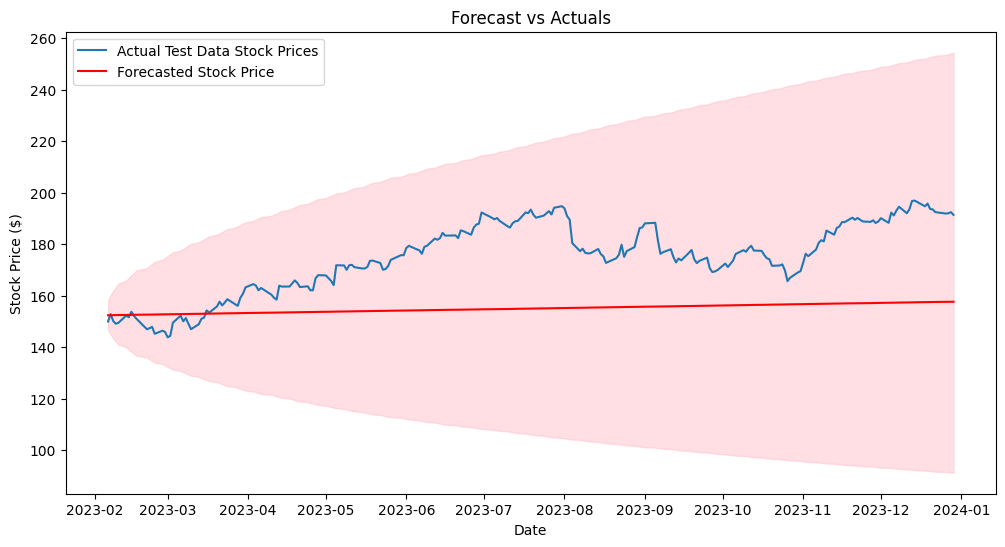

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_actual, label="Actual Test Data Stock Prices")
plt.plot(forecast_series, color="red", label="Forecasted Stock Price")
plt.fill_between(test_data_actual.index, lower_series, upper_series, color='pink', alpha=0.5)
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

Using the 1, 0, 1 model instead:

In [78]:
# Forecasting future stock prices based on ARIMA model fitted on log-differenced data
forecast_steps = len(test_data)

# Get forecasted differenced log values
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast_log_diff = forecast_results.predicted_mean

print(forecast_log_diff)
print()

# Reconstruct the forecasted log prices
last_log_price = df_close_log.loc[train_data.index[-1]]
print(last_log_price)

# Get the scalar log price
last_log_price_value = last_log_price.iloc[0]

# Correct the cumulative reconstruction
forecast_log_prices = last_log_price_value + forecast_log_diff.cumsum()
print(forecast_log_prices)

# Convert back to actual stock prices
forecast_series = np.exp(forecast_log_prices)

# Get confidence intervals and convert to original scale
conf_int = forecast_results.conf_int()
conf_lower = last_log_price + conf_int.iloc[:, 0].cumsum()
conf_upper = last_log_price + conf_int.iloc[:, 1].cumsum()

lower_series = np.exp(conf_lower)
upper_series = np.exp(conf_upper)

# Actual test prices (exponentiate log)
# test_data_actual = np.exp(test_data)
test_data_actual = np.exp(df_close_log.loc[test_data.index])

forecast_series = forecast_series[:len(test_data_actual)]
print(forecast_series)
lower_series = lower_series[:len(test_data_actual)]
upper_series = upper_series[:len(test_data_actual)]

# Align indexes
forecast_series.index = test_data_actual.index
lower_series.index = test_data_actual.index
upper_series.index = test_data_actual.index

2037    0.002082
2038    0.000979
2039    0.000898
2040    0.000892
2041    0.000891
          ...   
2258    0.000891
2259    0.000891
2260    0.000891
2261    0.000891
2262    0.000891
Name: predicted_mean, Length: 226, dtype: float64

Ticker
AAPL    5.010543
Name: 2023-02-06 00:00:00, dtype: float64
2037    5.012624
2038    5.013603
2039    5.014501
2040    5.015392
2041    5.016283
          ...   
2258    5.209656
2259    5.210547
2260    5.211438
2261    5.212329
2262    5.213220
Name: predicted_mean, Length: 226, dtype: float64
2037    150.298667
2038    150.445829
2039    150.580923
2040    150.715239
2041    150.849609
           ...    
2258    183.031038
2259    183.194212
2260    183.357533
2261    183.520998
2262    183.684610
Name: predicted_mean, Length: 226, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


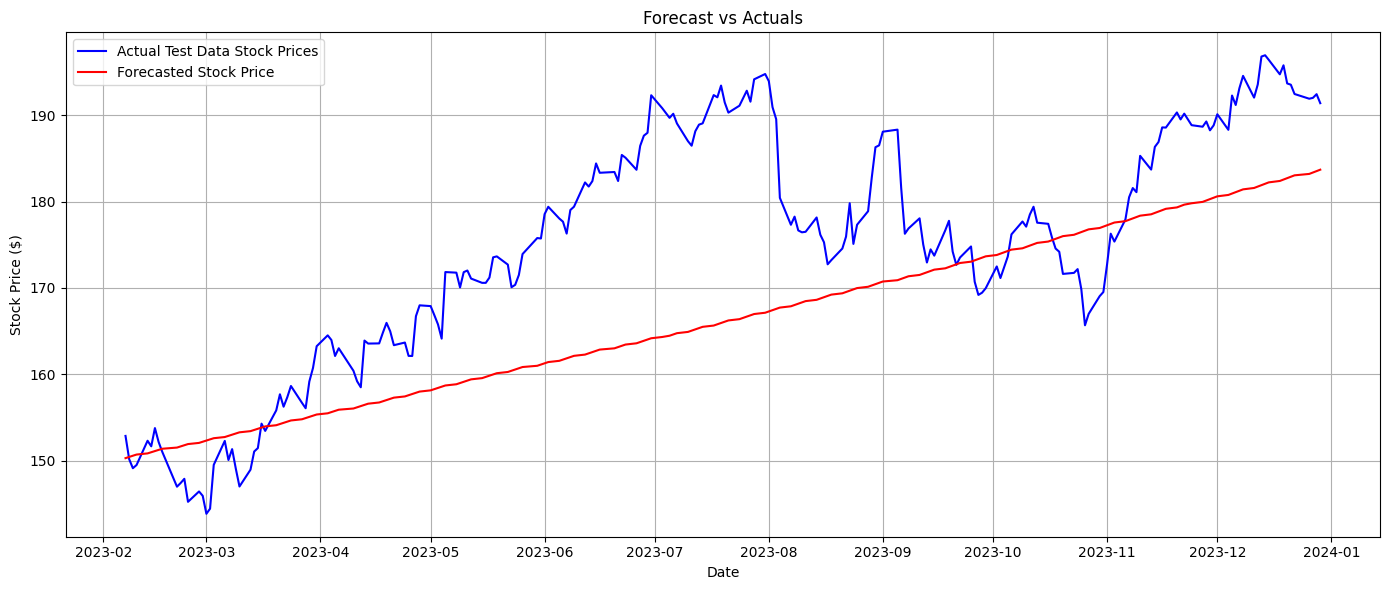

In [79]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(test_data_actual, label="Actual Test Data Stock Prices", color="blue")
plt.plot(forecast_series, label="Forecasted Stock Price", color="red")
plt.fill_between(forecast_series.index, lower_series, upper_series, color='pink', alpha=0.3)
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
# Evaluating forecast accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual = test_data_actual.values.flatten()
predicted = forecast_series.values.flatten()

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mse)

epsilon = 1e-6
mask = actual > epsilon
mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

print(f'Forecasted Stock Prices:\n{forecast_series}\n')
print(f'Actual Stock Prices:\n{test_data_actual}\n')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Forecasted Stock Prices:
Date
2023-02-06    152.426300
2023-02-07    152.449198
2023-02-08    152.472100
2023-02-09    152.495005
2023-02-10    152.517913
                 ...    
2023-12-22    157.595029
2023-12-26    157.618704
2023-12-27    157.642382
2023-12-28    157.666064
2023-12-29    157.689749
Length: 227, dtype: float64

Actual Stock Prices:
Ticker            AAPL
Date                  
2023-02-06  149.986099
2023-02-07  152.872543
2023-02-08  150.173904
2023-02-09  149.136002
2023-02-10  149.502289
...                ...
2023-12-22  192.444580
2023-12-26  191.897858
2023-12-27  191.997269
2023-12-28  192.424698
2023-12-29  191.380966

[227 rows x 1 columns]

Mean Absolute Error (MAE): 20.42
Mean Squared Error (MSE): 543.74
Root Mean Squared Error (RMSE): 23.32
Mean Absolute Percentage Error (MAPE): 11.26%


Using the SARIMAX model:

In [116]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 5),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_model_fit = sarimax_model.fit(disp=False)
print(sarimax_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                              AAPL   No. Observations:                 2037
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                5160.181
Date:                           Thu, 10 Apr 2025   AIC                         -10310.361
Time:                                   16:59:48   BIC                         -10282.297
Sample:                                        0   HQIC                        -10300.063
                                          - 2037                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1354      0.171      0.793      0.428      -0.199       0.470
ma.L1         -0.2153      0.171     -1.262

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


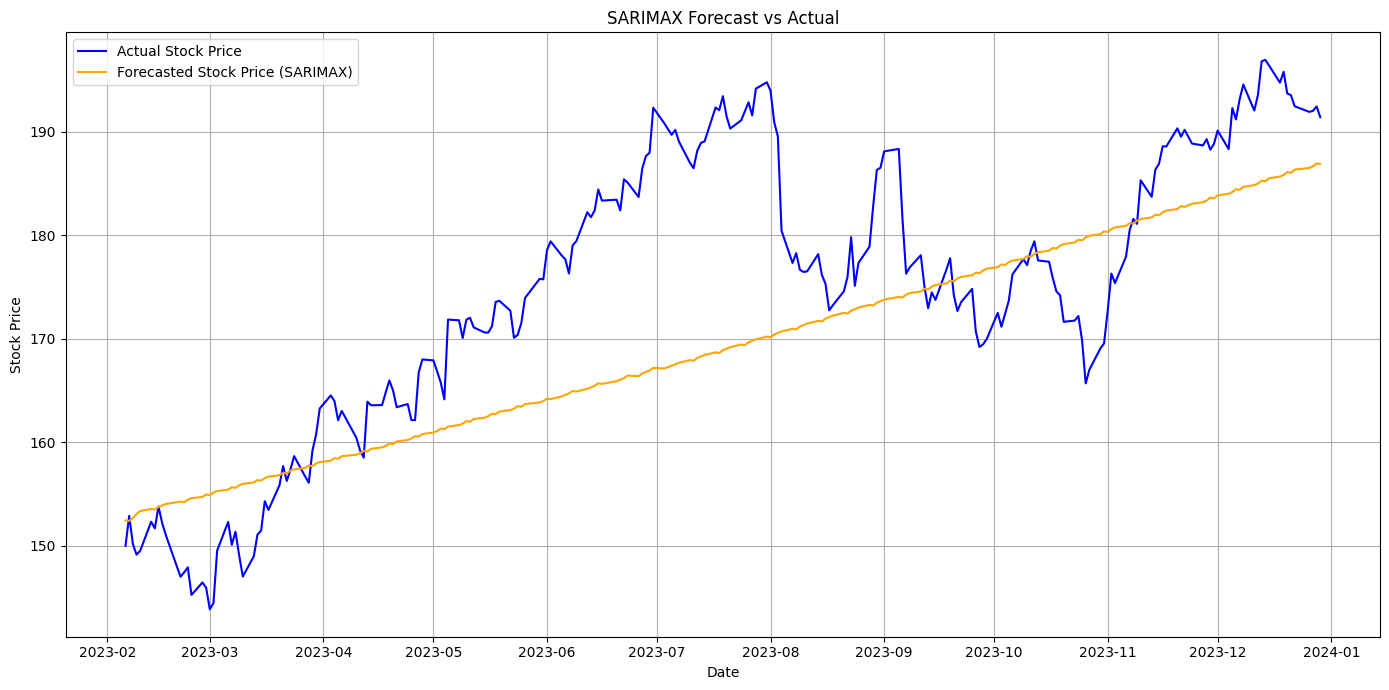

In [115]:
sarimax_forecast_steps = len(test_data)
sarimax_forecast_results = sarimax_model_fit.get_forecast(steps=sarimax_forecast_steps)
sarimax_forecast_log_diff = sarimax_forecast_results.predicted_mean

# Reconstruct log prices from differenced forecast
last_log_price = df_close_log.loc[train_data.index[-1]]
last_log_price_value = last_log_price.iloc[0]
sarimax_forecast_series = np.exp(sarimax_forecast_log_diff)

# Get confidence intervals
sarimax_conf_int = sarimax_forecast_results.conf_int()
sarimax_conf_lower = np.exp(sarimax_forecast_results.conf_int().iloc[:, 0])
sarimax_conf_upper = np.exp(sarimax_forecast_results.conf_int().iloc[:, 1])

sarimax_lower_series = np.exp(sarimax_conf_lower)
sarimax_upper_series = np.exp(sarimax_conf_upper)

sarimax_forecast_series = sarimax_forecast_series[:len(test_data_actual)]
# print(sarimax_forecast_series)
sarimax_lower_series = sarimax_lower_series[:len(test_data_actual)]
sarimax_upper_series = sarimax_upper_series[:len(test_data_actual)]

# Align indexes
sarimax_forecast_series.index = test_data_actual.index
sarimax_lower_series.index = test_data_actual.index
sarimax_upper_series.index = test_data_actual.index

# Compute error metrics
mae = mean_absolute_error(test_data_actual.values.flatten(), sarimax_forecast_series.values)
mse = mean_squared_error(test_data_actual.values.flatten(), sarimax_forecast_series.values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data_actual.values.flatten() - sarimax_forecast_series.values) / test_data_actual.values.flatten())) * 100

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_data_actual, label='Actual Stock Price', color='blue')
plt.plot(sarimax_forecast_series, label='Forecasted Stock Price (SARIMAX)', color='orange')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [118]:
# Flatten series for metric calculation
actual_sarimax = test_data_actual.values.flatten()
predicted_sarimax = sarimax_forecast_series.values.flatten()

# Error metrics
mae_sarimax = mean_absolute_error(actual_sarimax, predicted_sarimax)
mse_sarimax = mean_squared_error(actual_sarimax, predicted_sarimax)
rmse_sarimax = np.sqrt(mse_sarimax)

# MAPE with epsilon mask to avoid division by zero
epsilon = 1e-6
mask_sarimax = actual_sarimax > epsilon
mape_sarimax = np.mean(np.abs((actual_sarimax[mask_sarimax] - predicted_sarimax[mask_sarimax]) / actual_sarimax[mask_sarimax])) * 100

# Display results
print(f'Forecasted Stock Prices (SARIMAX):\n{sarimax_forecast_series}\n')
print(f'Actual Stock Prices:\n{test_data_actual}\n')
print(f'Mean Absolute Error (MAE): {mae_sarimax:.2f}')
print(f'Mean Squared Error (MSE): {mse_sarimax:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_sarimax:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_sarimax:.2f}%')

Forecasted Stock Prices (SARIMAX):
Date
2023-02-06    152.429238
2023-02-07    152.389166
2023-02-08    152.669004
2023-02-09    153.051407
2023-02-10    153.344144
                 ...    
2023-12-22    186.316913
2023-12-26    186.481488
2023-12-27    186.639575
2023-12-28    186.920437
2023-12-29    186.853176
Name: predicted_mean, Length: 227, dtype: float64

Actual Stock Prices:
Ticker            AAPL
Date                  
2023-02-06  149.986099
2023-02-07  152.872543
2023-02-08  150.173904
2023-02-09  149.136002
2023-02-10  149.502289
...                ...
2023-12-22  192.444580
2023-12-26  191.897858
2023-12-27  191.997269
2023-12-28  192.424698
2023-12-29  191.380966

[227 rows x 1 columns]

Mean Absolute Error (MAE): 8.22
Mean Squared Error (MSE): 110.78
Root Mean Squared Error (RMSE): 10.53
Mean Absolute Percentage Error (MAPE): 4.58%
